In [1]:
%matplotlib inline
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 

import pandas as pd
import seaborn as sns; sns.set()
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC


from sklearn.metrics import confusion_matrix

In [2]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [3]:
# path to seed-to-voxel matrices

path_to_files = "/home/xlajoie/Desktop/Seeds2voxels_n100"

In [4]:
path_list = glob.glob("Seeds2voxels_n100/*_Seeds2Voxels.nii.gz")
path_list.sort()

In [5]:
# get only the npy files out of the Seeds2voxels folder which also has nii.gz files 

ls_sub = [(file) for file in os.listdir(path_to_files) if file[-3:] == "npy"]

x_correl = []
y_sex = []
for filename in ls_sub:
    sub_id = filename.split("_")[0]
    # if sub_id is in csv
    if len(df.loc[df['subject_label'] == int(sub_id)]) != 0:
        x_correl.append(np.load(os.path.join(path_to_files, filename)).flatten())
        y_sex.append(df.loc[df['subject_label'] == int(sub_id)]["Gender"].values[0])

x_correl = np.asarray(x_correl)
    

In [6]:
print(sum(y_sex), len(y_sex))

40 78


In [7]:
# split the sample o training/test with a 80/20 % ratio 
# and stratify sex by class, also shuffle the data

X_train, X_test, y_train, y_test = train_test_split( 
                                                    x_correl,  # x 
                                                    y_sex,       # y 
                                                    test_size = 0.2, # 80%/20% split 
                                                    shuffle = True,  #shuffle dataset before splitting
                                                    stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                    random_state = 123) #same shuffle each time 

print('train:', len(X_train),'test:', len(X_test))




train: 62 test: 16


In [8]:
# comparing different # of features for find how many explain the most variance 

score = []
max_feature = int(0.9*len(X_train))
n_components_range = range(0, max_feature, 10) # A range of different values for n_components

for n_comp in tqdm(n_components_range):
    if n_comp == 0:
        model = LinearSVC(max_iter=2000)
    else:
        model = Pipeline([
            ('feature_selection', PCA(n_comp)),
            ('prediction', LinearSVC(max_iter=2000))
                      ])
    #score = cross_val_score(model, X_train, y_train, cv=10)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())


100%|█████████████████████████████████████████████| 6/6 [08:38<00:00, 86.50s/it]


In [9]:
print(score)
x = list(n_components_range)

[0.6928571428571428, 0.6476190476190475, 0.6404761904761904, 0.6476190476190475, 0.6428571428571429, 0.6238095238095239]


Text(0, 0.5, 'Cross_val Score')

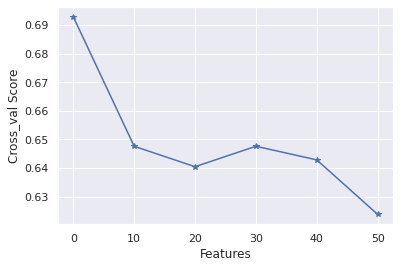

In [10]:
plt.plot(x,score, color = "b", marker = "*")
plt.xlabel("Features")
plt.ylabel("Cross_val Score")

In [11]:
best_ncomp = n_components_range[np.array(score).argmax()]
best_ncomp

0

In [12]:
# Now that we know how many features explain the most variance, we can put the number here 

#pca = PCA(n_components=5)  #top 5 which explain the most variance found from the 
#pca.fit(x_correl)
#X_features = pca.transform(x_correl)
#print(X_features)

In [13]:
if best_ncomp == 0:
    model = LinearSVC(max_iter=2000)
else:
    model = Pipeline([
            ('feature_selection', PCA(best_ncomp)),
            ('prediction', LinearSVC(max_iter=2000))
                      ])
model.fit(X_train,y_train) #fit the model/ train the model
y_pred = model.predict(X_test)

#calculate the model accuracy
acc = model.score(X_test, y_test)

#compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
print(df.head())

# print results
print('accuracy (r2) =', acc)



       Positive  Negative
True          6         2
False         0         8
accuracy (r2) = 0.875


In [14]:
df = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
df

,Positive,Negative
True,6,2
False,0,8


In [69]:
coef= model.coef_[0]
coef_reshape = np.reshape(coef, (8, 193369))
coef_reshape

array([[ 1.36475495e-06, -9.87819341e-05, -1.70853320e-05, ...,
         3.73690882e-05,  6.07559028e-06,  5.95541848e-06],
       [ 4.86864658e-06, -5.34868456e-05, -3.85114117e-05, ...,
        -5.35429625e-05,  1.07568074e-05, -5.68645821e-06],
       [-1.59411367e-06, -3.60149501e-05,  3.70606090e-05, ...,
        -1.71100941e-05, -2.81519874e-05,  8.64725547e-06],
       ...,
       [ 8.98285853e-06, -2.37361785e-06,  2.58994519e-05, ...,
         9.39746632e-05,  7.45835081e-05,  1.00464321e-04],
       [ 8.54829179e-05,  5.60561043e-05,  9.13505416e-05, ...,
        -3.64804271e-05,  9.56404308e-06,  1.27779697e-04],
       [ 3.06900346e-05, -1.03052615e-04, -1.32766946e-04, ...,
        -3.94461053e-05, -4.25329360e-05, -6.39278297e-05]])

In [45]:
#coef = model[1].coef_
#coef = model[0].inverse_transform(coef)

# Next Steps 

#### Import masker

In [1]:
#from nilearn.maskers import NiftiMasker
#brain_masker = NiftiMasker(smoothing_fwhm=6, detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2,
#                                   memory='nilearn_cache', memory_level=1, verbose=0)

In [2]:
#import nilearn
#masker = "/home/xlajoie/Desktop/masker.nii.gz"
#mask = nilearn.masking.unmask(coef_reshape[0], masker)

In [3]:
#coef_reshapeDF = pd.DataFrame(coef_reshape)

#print(coef_reshapeDF.to_numerics())

#### Plot the main features on a brain 

In [4]:
#from nilearn import plotting

#display = plotting.plot_stat_map(pd.to_numeric(coef_reshapeDF[0]),
#                                 threshold=None, vmax=1,
 #                                cut_coords=None,
 #                                title="coef",
  #                               )
#display.add_markers(marker_coords=None, marker_color='g',
#                        marker_size=50)